# Inference API: Tutorial using ONNX

[![View on GitHub](https://img.shields.io/badge/View-on%20GitHub-lightgrey?logo=github)](https://github.com/Dana-Farber-AIOS/pathml/blob/master/examples/)

## Introduction

This notebook is a tutorial on how to use the future ONNX `inference` feature in PathML. 

Some notes:
- The ONNX inference pipeline uses the existing PathML Pipeline and Transforms infrastructure.
    - ONNX labels are saved to a `pathml.core.slide_data.SlideData` object as `tiles`.
    - Users can iterate over the tiles as they would when using this feature for preprocessing. 
- Preprocessing images before inference
    - Users will need to create their own bespoke `pathml.preprocessing.transforms.transform` method to preprocess images before inference if necessary.
    - A guide on how to create preprocessing pipelines is [here](https://pathml.readthedocs.io/en/latest/creating_pipelines.html). 
    - A guide on how to run preprocessing pipelines is [here](https://pathml.readthedocs.io/en/latest/running_pipelines.html). 
- ONNX Model Initializers 
    - ONNX models often have neural network initializers stored in the input graph. This means that the user is expected to specify initializer values when running inference. To solve this issue, we have a function that removes the network initializers from the input graph. This functions is adopted from the `onnxruntime` [github](https://github.com/microsoft/onnxruntime/blob/main/tools/python/remove_initializer_from_input.py).  
    - We also have a function that checks if the initializers have been removed from the input graph before running inference. Both of these functions are described more below. 
- When using a model stored remotely on HuggingFace, the model is *downloaded locally* before being used. The user will need to delete the model after running `Pipeline` with a method that comes with the model class. An example of how to do this is below. 

## Quick Sample Code
- Below is an example of how users would use the ONNX inference feature in PathML with a locally stored model.
```python
# load packages
from pathml.core import SlideData

from pathml.preprocessing import Pipeline
import pathml.preprocessing.transforms as Transforms

from pathml.inference import Inference, remove_initializer_from_input

# Define slide path
slide_path = 'PATH TO SLIDE'

# Set path to model 
model_path = 'PATH TO ONNX MODEL'
# Define path to export fixed model
new_path = 'PATH TO SAVE NEW ONNX MODEL'

# Fix the ONNX model by removing initializers. Save new model to `new_path`. 
remove_initializer_from_input(model_path, new_path) 

inference = Inference(model_path = new_path, input_name = 'data', num_classes = 8, model_type = 'segmentation')

# Create a transformation list
transformation_list = [
    inference
] 

# Initialize pathml.core.slide_data.SlideData object
wsi = SlideData(slide_path, stain = 'Fluor')

# Set up PathML pipeline
pipeline = Pipeline(transformation_list)

# Run Inference
wsi.run(pipeline, tile_size = 1280, level = 0)
```

- Below is an example of how users would use the ONNX inference feature in PathML with a model stored in the public HuggingFace repository.
```python
# load packages
from pathml.core import SlideData

from pathml.preprocessing import Pipeline
import pathml.preprocessing.transforms as Transforms

from pathml.inference import RemoteTestHoverNet

# Define slide path
slide_path = 'PATH TO SLIDE'

inference = RemoteTestHoverNet()

# Create a transformation list
transformation_list = [
    inference
] 

# Initialize pathml.core.slide_data.SlideData object
wsi = SlideData(slide_path)

# Set up PathML pipeline
pipeline = Pipeline(transformation_list)

# Run Inference
wsi.run(pipeline, tile_size = 256)

# DELETE ONNX MODEL DOWNLOADED FROM HUGGINGFACE
inference.remove() 
```

## Load Packages

**NOTE**
- Please put in your environment name in the following line if you are using a jupyter notebook. If not, you may remove this line. 
    `os.environ["JAVA_HOME"] = "/opt/conda/envs/YOUR ENVIRONMENET NAME"` 

In [8]:
import os

os.environ["JAVA_HOME"] = (
    "/opt/conda/envs/YOUR ENVIRONMENET NAME"  # TO DO: CHANGE THIS TO YOUR ENVIRONMENT NAME
)
import numpy as np
import onnx
import onnxruntime
import requests
import torch

from pathml.core import SlideData, Tile
from dask.distributed import Client
from pathml.preprocessing import Pipeline
import pathml.preprocessing.transforms as Transforms

import matplotlib.pyplot as plt
import matplotlib

from PIL import Image

## ONNX Inference Class and ONNX Model Fixer

- Here is the raw code for the functions that handle the initializers in the ONNX model and the classes that run the inference.

### Functions to remove initializers and check that initializers have been removed.

- `remove_initializer_from_input`
    - This function removes any initializers from the input graph of the ONNX model.
    - Without removing the initializers from the input graph, users will not be able to run inference.
    - Adapted from the `onnxruntime` [github](https://github.com/microsoft/onnxruntime/blob/main/tools/python/remove_initializer_from_input.py).  
    - Users specify:
        - `model_path` (str): path to ONNX model,
        - `new_path` (str): path to save adjusted model w/o initializers
    - We will run this function on all models placed in our model zoo, so users will not have to run it unless they are working with their own local models.
    
 <br> 
 
- `check_onnx_clean`
    - Checks if the initializers are in the input graph
    - Returns `True` and a `ValueError` if there are initializers in the input graph
    - Adapted from the `onnxruntime` [github](https://github.com/microsoft/onnxruntime/blob/main/tools/python/remove_initializer_from_input.py). 
    - Users specify:
        - `model_path` (str): path to ONNX model

 <br> 

 - `convert_pytorch_onnx` 
    - Converts a PyTorch `.pt` file to `.onnx`
    - Wrapper function of the [PyTorch](https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html) function to handle the conversion.
    - Users specify:
        - model_path (torch.nn.Module Model): Pytorch model to be converted,
        - dummy_tensor (torch.tensor): dummy input tensor that is an example of what will be passed into the model,
        - model_name (str): name of ONNX model created with .onnx at the end,
        - opset_version (int): which opset version you want to use to export
        - input_name (str): name assigned to dummy_tensor
    - Note that the model class must be defined before loading the `.pt` file and set to eval before calling this function. 

### Inference Classes

<br> 

- `InferenceBase`
    - This class inherits from `pathml.preprocessing.transforms.transform`, similar to all of the preprocessing transformations. Inheriting from `transforms.transform` allows us to use the existing `Pipeline` function in PathML which users should be familar with.  
    - This is the base class for all Inference classes for ONNX modeling
    - Each instance of a class also comes with a `model_card` which specifies certain details of the model in dictionary form. The default parameters are:
        -   ```python 
                self.model_card = {
                'name' : None, 
                'num_classes' : None,
                'model_type' : None, 
                'notes' : None,  
                'model_input_notes': None, 
                'model_output_notes' : None,
                'citation': None } 
            ``` 
       - Model cards are where important information about the model should be kept. Since they are in dictionary form, the user can add keys and values as they see fit. 
       - This class also has getter and setter functions to adjust the `model_card`. Certain functions include `get_model_card`, `set_name`, `set_num_classes`, etc. 
 
  <br> 
  
- `Inference` 
    - This class is for when the user wants to use an ONNX model stored locally. 
    - Calls the `check_onnx_clean` function to check if the model is clean.
    - Users specify:
        - `model_path` (str): path to ONNX model,
        - `input_name` (str): name of input for ONNX model, *defaults to `data`* 
        - `num_classes` (int): number of outcome classes, 
        - `model_type` (str): type of model (classification, segmentation) 
        - `local` (bool): if you are using a local model or a remote model, *defaults to `True`* 
 
  <br> 
  
- `HaloAIInference`
    - This class inherits from `Inference`
    - HaloAI ONNX models always return 20 prediction maps: this class will subset and return the necessary ones. 

<br> 

- `RemoteTestHoverNet` 
    - This class inherits from `Inference` and is the test class for public models hosted on `HuggingFace`. 
    - `local` is automatically set to `False` 
    - Our current test model is a HoverNet from [TIAToolbox](https://github.com/TissueImageAnalytics/tiatoolbox)
    - Pocock J, Graham S, Vu QD, Jahanifar M, Deshpande S, Hadjigeorghiou G, Shephard A, Bashir RM, Bilal M, Lu W, Epstein D. TIAToolbox as an end-to-end library for advanced tissue image analytics. Communications medicine. 2022 Sep 24;2(1):120.
    - Its `model_card` is:
        -   ```python 
                {'name': 'Tiabox HoverNet Test',
                 'num_classes': 5,
                 'model_type': 'Segmentation',
                 'notes': None,
                 'model_input_notes': 'Accepts tiles of 256 x 256',
                 'model_output_notes': None,
                 'citation': 'Pocock J, Graham S, Vu QD, Jahanifar M, Deshpande S, Hadjigeorghiou G, Shephard A, Bashir RM, Bilal M, Lu W, Epstein D. TIAToolbox as an end-to-end library for advanced tissue image analytics. Communications medicine. 2022 Sep 24;2(1):120.'}
             ```

<br> 

- `RemoteMesmer` 
    - This class inherits from `Inference` and is hosted on `HuggingFace`. 
    - `local` is automatically set to `False` 
    - This model is from [Deepcell](https://github.com/vanvalenlab/deepcell-tf/blob/master/deepcell/applications/mesmer.py)
    - Greenwald NF, Miller G, Moen E, Kong A, Kagel A, Dougherty T, Fullaway CC, McIntosh BJ, Leow KX, Schwartz MS, Pavelchek C. Whole-cell segmentation of tissue images with human-level performance using large-scale data annotation and deep learning. Nature biotechnology. 2022 Apr;40(4):555-65.
    - Its `model_card` is:
        -   ```python 
                {'name': "Deepcell's Mesmer",
                 'num_classes': 3,
                 'model_type': 'Segmentation',
                 'notes': None,
                 'model_input_notes': 'Accepts tiles of 256 x 256',
                 'model_output_notes': None,
                 'citation': 'Greenwald NF, Miller G, Moen E, Kong A, Kagel A, Dougherty T, Fullaway CC, McIntosh BJ, Leow KX, Schwartz MS, Pavelchek C. Whole-cell segmentation of tissue images with human-level performance using large-scale data annotation and deep learning. Nature biotechnology. 2022 Apr;40(4):555-65.'}

## Try it Yourself!

- What you need:
    - An ONNX model stored locally
    - An image with which you want to run inference stored locally
    - PathML already downloaded 

- Make sure to define the `Inference` class and `remove_initializer_from_input` above in the previous seciton if you have not downloaded the latest version of PathML.

- You will need to define the following variables: 
    - `slide_path`: 'PATH TO SLIDE'
    - `model_path`: 'PATH TO ONNX MODEL'
    - `new_path`: 'PATH TO SAVE FIXED ONNX MODEL'
    - `num_classes`: 'NUMBER OF CLASSES IN YOUR DATASET'
    - `tile_size`: 'TILE SIZE THAT YOUR ONNX MODEL ACCEPTS'
    
- The code in the cell below assumes you want the images passed in as is. If you need to select channels, you will need to add another `transform` method to do so before the inference transform. The following code provides an example if you want to subset into the first channel of an image. *Remember that PathML reads images in as XYZCT.* 

```python 
class convert_format(Transforms.Transform):
    def F(self, image):
        # orig = (1280, 1280, 1, 6, 1) = (XYZCT)
        image = image[:, :, :, 0, ...] # this will make the tile (1280, 1280, 1, 1)
        return image

    def apply(self, tile):
        tile.image = self.F(tile.image)
        
convert = convert_format()
inference = Inference(
    model_path = 'PATH TO LOCAL MODEL', 
    input_name = 'data', 
    num_classes = 'NUMBER OF CLASSES' , 
    model_type = 'CLASSIFICATION OR SEGMENTATION', 
    local = True)

transformation_list = [convert, inference] 

```

### Converting a Pytorch Model to ONNX Using the `convert_pytorch_onnx` Function

Note the following:
- Similar to PyTorch, you will need to define and create an instance of you model class before loading the `.pt` file. Then you will need to set it to eval mode before calling the conversion function. The code to do these steps is below.

In [ ]:
# Define your model class
num_input, num_output, batch_size = 10, 1, 1


class SimpleModel(torch.nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.linear = torch.nn.Linear(num_input, num_output)
        torch.nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, x):
        y = self.linear(x)
        return y


# Define your model var
model = SimpleModel()

# Export model as .pt if you haven't already done so
# If you have already exported a .pt file, you will still need to define a model class, initialize it, and set it to eval mode.
# If you saved your model using `torch.jit.script`, you will not need to define your model class and instead load it using `torch.jit.load` then set it to eval mode.
torch.save(model, "test.pt")

# Load .pt file
model_test = torch.load("test.pt")
# Set model to eval mode
model_test.eval()

# Define a dummy tensor (this is an example of what the ONNX should expect during inference)
x = torch.randn(batch_size, num_input)

# Run conversion function
convert_pytorch_onnx(
    model=model_test, dummy_tensor=x, model_name="NAME_OF_OUTPUT_MODEL_HERE.onnx"
)

### Local ONNX Model Using the `Inference` Class

In [ ]:
# Define slide path
slide_path = "PATH TO SLIDE"

# Set path to model
model_path = "PATH TO ONNX MODEL"
# Define path to export fixed model
new_path = "PATH TO SAVE NEW ONNX MODEL"


# Fix the ONNX model
remove_initializer_from_input(model_path, new_path)

inference = Inference(
    model_path=new_path,
    input_name="data",
    num_classes="NUMBER OF CLASSES",
    model_type="CLASSIFICATION OR SEGMENTATION",
    local=True,
)

transformation_list = [inference]

# Initialize pathml.core.slide_data.SlideData object
wsi = SlideData(slide_path)

# Set up PathML pipeline
pipeline = Pipeline(transformation_list)

# Run Inference
# Level is equal to 0 for highest resolution (Note that this is the default setting)
wsi.run(pipeline, tile_size="TILE SIZE THAT YOUR ONNX MODEL ACCEPTS", level=0)

### Local ONNX Model Using the `HaloAIInference` Class

In [ ]:
# Define slide path
slide_path = "PATH TO SLIDE"

# Set path to model
model_path = "PATH TO ONNX MODEL"
# Define path to export fixed model
new_path = "PATH TO SAVE NEW ONNX MODEL"


# Fix the ONNX model
remove_initializer_from_input(model_path, new_path)

inference = HaloAIInference(
    model_path=new_path,
    input_name="data",
    num_classes="NUMBER OF CLASSES",
    model_type="CLASSIFICATION OR SEGMENTATION",
    local=True,
)

transformation_list = [inference]

# Initialize pathml.core.slide_data.SlideData object
wsi = SlideData(slide_path)

# Set up PathML pipeline
pipeline = Pipeline(transformation_list)

# Run Inference
# Level is equal to 0 for highest resolution (Note that this is the default setting)
wsi.run(pipeline, tile_size="TILE SIZE THAT YOUR ONNX MODEL ACCEPTS", level=0)

### Remote ONNX Using our `RemoteTestHoverNet` Class
- Uses a Hovernet from [TIAToolbox](https://github.com/TissueImageAnalytics/tiatoolbox) 
- This version of Hovernet was trained on the [MoNuSAC](https://monusac-2020.grand-challenge.org/) dataset.
- Note that the purpose of this model is to illustrate how PathML will handle future remote models. We plan on release more public models to our model zoo on HuggingFace in the future.
- Citation for model:
    - Pocock J, Graham S, Vu QD, Jahanifar M, Deshpande S, Hadjigeorghiou G, Shephard A, Bashir RM, Bilal M, Lu W, Epstein D. TIAToolbox as an end-to-end library for advanced tissue image analytics. Communications medicine. 2022 Sep 24;2(1):120.
- Make sure your image has 3 channels! 
- When the `RemoteTestHoverNet` is first initialized, it downloads the HoverNet from HuggingFace and saves it locally on your own system as `temp.onnx`. 
    - **You will need to remove it manually by calling the `remove()` method** An example of how to call this method is in the last line in the code below. 

In [ ]:
# Define slide path
slide_path = "PATH TO SLIDE"

inference = RemoteTestHoverNet()

# Create a transformation list
transformation_list = [inference]

# Initialize pathml.core.slide_data.SlideData object
wsi = SlideData(slide_path)

# Set up PathML pipeline
pipeline = Pipeline(transformation_list)

# Run Inference
wsi.run(pipeline, tile_size=256)

# DELETE ONNX MODEL DOWNLOADED FROM HUGGINGFACE
inference.remove()

## Iterate over the tiles

Now that you have your tiles saved to your SlideData object, you can now iterate over them.

For example, if you wanted to check the shape of the tiles you could run the following code: 

```python
for tile in wsi.tiles: 
    print(tile.image.shape) 
```

To see how to use these tiles to make visualizations, see below.

## Full Example With Vizualization of Output

The `RemoteTestHoverNet()` uses a pretrained HoverNet from TIAToolBox trained on the [MoNuSAC](https://monusac-2020.grand-challenge.org/) dataset. **The model was trained to accept tiles of 256x256 to create a prediction matrix of size 164x164 with 9 channels.** The first 5 channels correspond to the Nuclei Types (TP), the next two channels correspond to the Nuclei Pixels (NP), and the last two channels correspond to the Hover (HV). The documention for these channels can be found here on TIAToolBox's [website](https://tia-toolbox.readthedocs.io/en/v1.0.1/_modules/tiatoolbox/models/architecture/hovernet.html#HoVerNet.infer_batch).  

In this example we use an taken from the [MoNuSAC](https://monusac-2020.grand-challenge.org/) dataset. See citation in the `References` section.

### Run Code as Demonstrated Above

Note that to run the following code, you will need to download and save the image titled `TCGA-5P-A9K0-01Z-00-DX1_1.svs` in the same directory as the notebook.

In [3]:
# Define slide path
slide_path = "TCGA-5P-A9K0-01Z-00-DX1_1.svs"

inference = RemoteTestHoverNet()

# Create a transformation list
transformation_list = [inference]

# Initialize pathml.core.slide_data.SlideData object
wsi = SlideData(slide_path)

# Set up PathML pipeline
pipeline = Pipeline(transformation_list)

# Run Inference
wsi.run(pipeline, tile_size=256, tile_stride=164, tile_pad=True)

# DELETE ONNX MODEL DOWNLOADED FROM HUGGINGFACE
inference.remove()

Let's look at the first tile which comes from the top left corner (0,0) and Nucleus Pixel predictions.

In [4]:
for tile in wsi.tiles:
    # Create empty numpy array
    a = np.empty((2, 164, 164), dtype=object)
    # Get Nucleus Predictions
    classes = tile.image[0, 5:7, :, :]
    a = classes
    # Take the argmax to make the predictions binary
    image = np.argmax(a, axis=0)
    # Multiple values by 255 to make the array image friendly
    image = image * (255 / 1)
    # Make a grey scale image
    img = Image.fromarray(image.astype("uint8"), "L")
    # Save Image
    img.save("test_array_1.png")
    # Can break after one iteration since we are using at the tile at (0, 0).
    break

Lets visualize the tile vs the tile predictions. Since the model uses a 256x256 tile to create a prediction map of size 164x164, we need to take our tile located at (0,0) and crop it down to the center 164x164 pixes. 

In [5]:
prediction_dim = 164
tile_dim = 256
crop_amount = int((256 - 164) / 2)
wsi = SlideData(slide_path)

generator = wsi.generate_tiles(shape=(tile_dim, tile_dim), level=0)

for tile in generator:
    # Extract array from tile
    image = tile.image
    # Crop tile
    image = image[
        crop_amount : crop_amount + prediction_dim,
        crop_amount : crop_amount + prediction_dim,
    ]
    # Convert array to image
    img = Image.fromarray(image)
    # Save Image
    img.save("raw_tile.png")
    break

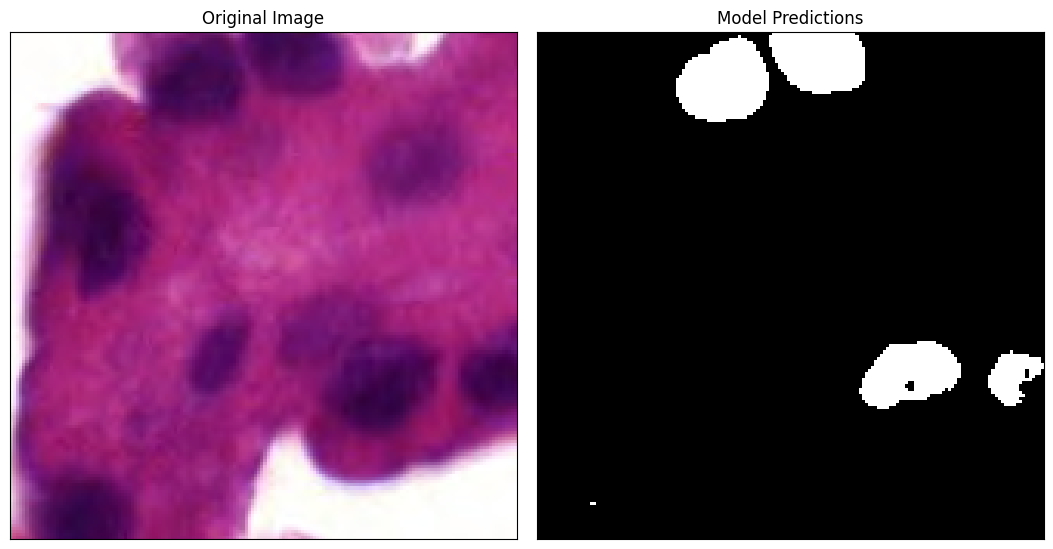

In [12]:
# Set figure sice
plt.rcParams["figure.figsize"] = 11, 8

# Read images
img_A = matplotlib.image.imread("raw_tile.png")
img_B = matplotlib.image.imread("test_array_1.png")

# Set up plots
fig, ax = plt.subplots(1, 2)
plt.xticks([])
plt.yticks([])
ax[0].imshow(img_A)
ax[1].imshow(img_B, cmap="gray")
ax[0].set_title("Original Image")
ax[1].set_title("Model Predictions")
plt.tight_layout()

# Get rid of tick marks
for a in ax.ravel():
    a.set_xticks([])
    a.set_yticks([])

# Show images
plt.show()

## References

- Pocock J, Graham S, Vu QD, Jahanifar M, Deshpande S, Hadjigeorghiou G, Shephard A, Bashir RM, Bilal M, Lu W, Epstein D. TIAToolbox as an end-to-end library for advanced tissue image analytics. Communications medicine. 2022 Sep 24;2(1):120.

- R. Verma, et al. "MoNuSAC2020: A Multi-organ Nuclei Segmentation and Classification Challenge." IEEE Transactions on Medical Imaging (2021).

- https://github.com/microsoft/onnxruntime/blob/main/tools/python/remove_initializer_from_input.py

- https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html